In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def suffix_dupIndex(df, add_one_subfix=False):
    dup_labels = df.index.duplicated(keep=False)
    dup_count = dup_labels.sum()
    if dup_count > 0:
        new_labels = []
        label_counts = {}
        for i, label in enumerate(df.index):
            if label in label_counts:
                label_counts[label] += 1
                new_labels.append(f"{label}_{label_counts[label]+1}")
            else:
                label_counts[label] = 0
                if dup_labels[i] or add_one_subfix:
                    new_labels.append(f"{label}_{label_counts[label]+1}")
                else:
                    new_labels.append(label)
        # df.index = new_labels
        return new_labels
    
def getEntPath(section, data_split):
    file_dir = str((Path().absolute()).parents[0]) + f"/PL-Marker/_statistics_data/{section}"
    ent_path = f"{file_dir}/{data_split}_ent.csv"
    rel_path = f"{file_dir}/{data_split}_rel.csv"
    return ent_path, rel_path

# Import data

In [88]:
data_df = {}
for data_split in ["train", "val"]:
    ent_path, rel_path = getEntPath("summary", data_split)
    ent_df = pd.read_csv(ent_path, index_col=0).drop_duplicates()
    rel_df = pd.read_csv(rel_path, index_col=0).drop_duplicates()
    data_df[data_split] = ent_df.merge(rel_df, on=['paper_id', 'summary']).drop_duplicates()
    print(f"Merge: {len(data_df[data_split])}\tEnt: {len(ent_df)}\tRel: {len(rel_df)}")
data_df["train"].head()

Merge: 18933	Ent: 18933	Rel: 18933
Merge: 3604	Ent: 3604	Rel: 3604


,paper_id,summary,Method,OtherScientificTerm,Task,Generic,Material,Metric,PART-OF,USED-FOR,FEATURE-OF,CONJUNCTION,EVALUATE-FOR,HYPONYM-OF,COMPARE
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge - less re...,3,2,1,0,0,0,0,3,0,0,0,0,0
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,5,4,0,1,0,0,0,5,1,1,0,0,0
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,2,2,1,6,0,0,0,4,0,1,2,0,0
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,4,1,3,2,0,0,0,5,0,0,0,0,0
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,7,3,4,2,0,0,0,5,0,4,1,5,0


# Kmeans Clustering

## Import and Define class

In [89]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'
from transformers import BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
def get_token(sentence, get_len=True):
    tokens = tokenizer.encode(
        sentence, 
        # padding='max_length',  
        # max_length=args.max_input, 
        truncation=True, 
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    if get_len: return tokens.shape[1]
    else: return tokens

In [165]:
from sklearn.preprocessing import StandardScaler

class kmeans_model:
    def __init__(self, df_dict, k):
        self.k = k
        df_train = df_dict['train']
        self.feature_col = [col for col in df_train.select_dtypes(['int'])]
        X = self.tranform_input(df_train, train=True)
        self.model = KMeans(n_clusters=self.k, random_state=42).fit(X)
        self.cluster_dict = {}
        for k, v in df_dict.items():
            self.cluster_dict[k] = self.get_cluster(v)
            print(f"Finished clustering {k} data")
        
    def tranform_input(self, df, train=False):
        if 'cluster' in self.feature_col: self.feature_col.remove('cluster')
        X_array = np.array([list(df[col]) for col in self.feature_col]).T
        if train:
            self.scaler = StandardScaler()
            self.scaler.fit(X_array)
        return self.scaler.transform(X_array)

    def get_cluster(self, df):
        X = self.tranform_input(df)
        labels = self.model.predict(X)
        cluster_df = df.copy()
        cluster_df['cluster'] = labels
        return cluster_df
        # return labels
    
    def plot_entities(self, data_split, type=None, title='Number of entities'):
        cluster_df = (self.cluster_dict[data_split]).copy()
        if type=="perc":
            for col in self.feature_col: cluster_df[col] = cluster_df[col]/max(cluster_df[col])*100
        df_boxplot = pd.DataFrame()
        for i in range(self.k):
            df_boxplot_ = pd.melt(cluster_df[cluster_df['cluster']==i], value_vars=self.feature_col, var_name="input_features")
            df_boxplot_['cluster'] = i+1
            df_boxplot = pd.concat([df_boxplot, df_boxplot_])
        df_boxplot.rename(columns={'value': "No. of Ent."}, inplace=True)
        self.get_boxplot(
            df_boxplot, 
            x='input_features', 
            y='No. of Ent.', 
            graph_title=title,
            hue='cluster',
            w=len(self.feature_col)*self.k/2
        )
        return cluster_df
        
    def plot_tokenlen(self, data_split, title=None, type="dist"):
        # type: boxplot, dist
        if title==None: title='Number of entities'
        token_df = (self.cluster_dict[data_split]).copy()
        token_df['token_len'] = token_df['summary'].apply(get_token)
        if type=='boxplot':
            self.get_boxplot(
                token_df, 
                x='cluster', 
                y='token_len', 
                graph_title=title,
            )
        elif type=='dist':
            print("dist")
        return token_df
    
    def get_boxplot(self, df, x, y, graph_title, hue=None, hue_title=None, w=5):
        plt.rcParams["figure.figsize"] = [w, 5]
        plt.rcParams["figure.autolayout"] = True
        sns.boxplot(x=x, y=y, hue=hue, data=df, palette="Set1")
        plt.title(graph_title)
        if hue!=None:
            if hue_title==None: hue_title = hue
            plt.legend(bbox_to_anchor=(1.05, 1), title=hue, loc='upper left', borderaxespad=0)
        plt.show()
        
    def export_cluster(self, data_split, exp_dir=""):
        exp_df = self.cluster_dict[data_split][["paper_id", "summary", "cluster"]]
        exp_df['sum_id'] = suffix_dupIndex(exp_df.set_index("paper_id"), add_one_subfix=True)
        filename = f"kmeans-k{self.k}-{data_split}"
        ver  = -1
        for file in sorted(os.listdir()):
            if file[:len(filename)]==filename:
                f = file.split(".")[0].split("-")[-1]
                if f[0]=='v' and f[1:].isdigit():
                    ver = max(ver, int(f[1:]))
        if exp_dir!="" and exp_dir[-1]!='/': exp_dir+='/'
        if exp_dir!="" and not os.path.exists(exp_dir): os.makedirs(exp_dir)
        exp_path = f"{exp_dir}{filename}-v{ver+1}.csv"
        
        exp_df.to_csv(exp_path, index=0)
        print(f"Saved {len(exp_df)} sample to {exp_path}")
        
    def get_num_paper(self, data_split):
        df_count = self.cluster_dict[data_split][["paper_id", "cluster"]].groupby("cluster").count()
        df_count.rename(columns={"paper_id": "num_paper"}, inplace=True)
        df_count["num_paper(%)"] = df_count["num_paper"]/df_count["num_paper"].sum()*100
        return df_count
        


## Clustering

In [166]:
model = kmeans_model(data_df, k=3)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Finished clustering train data
Finished clustering val data


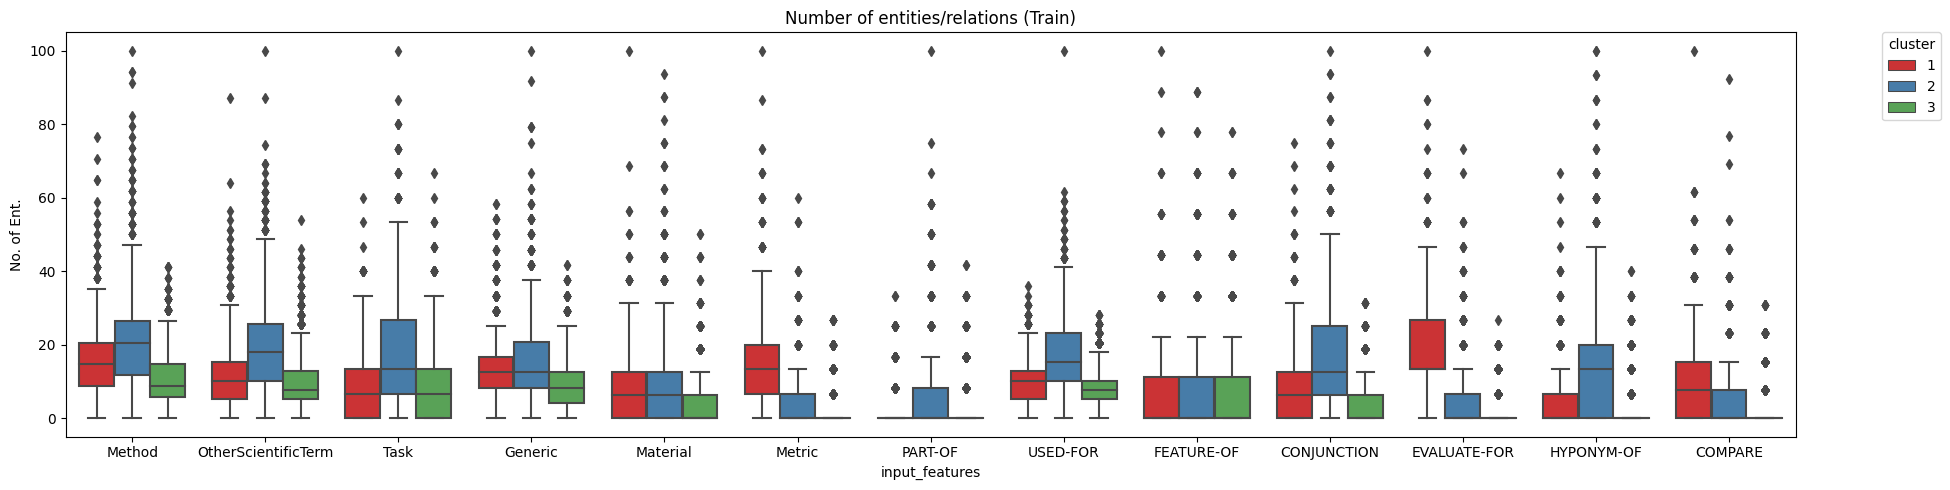

In [167]:
clust_df = model.plot_entities("train", title="Number of entities/relations (Train)", type='perc')

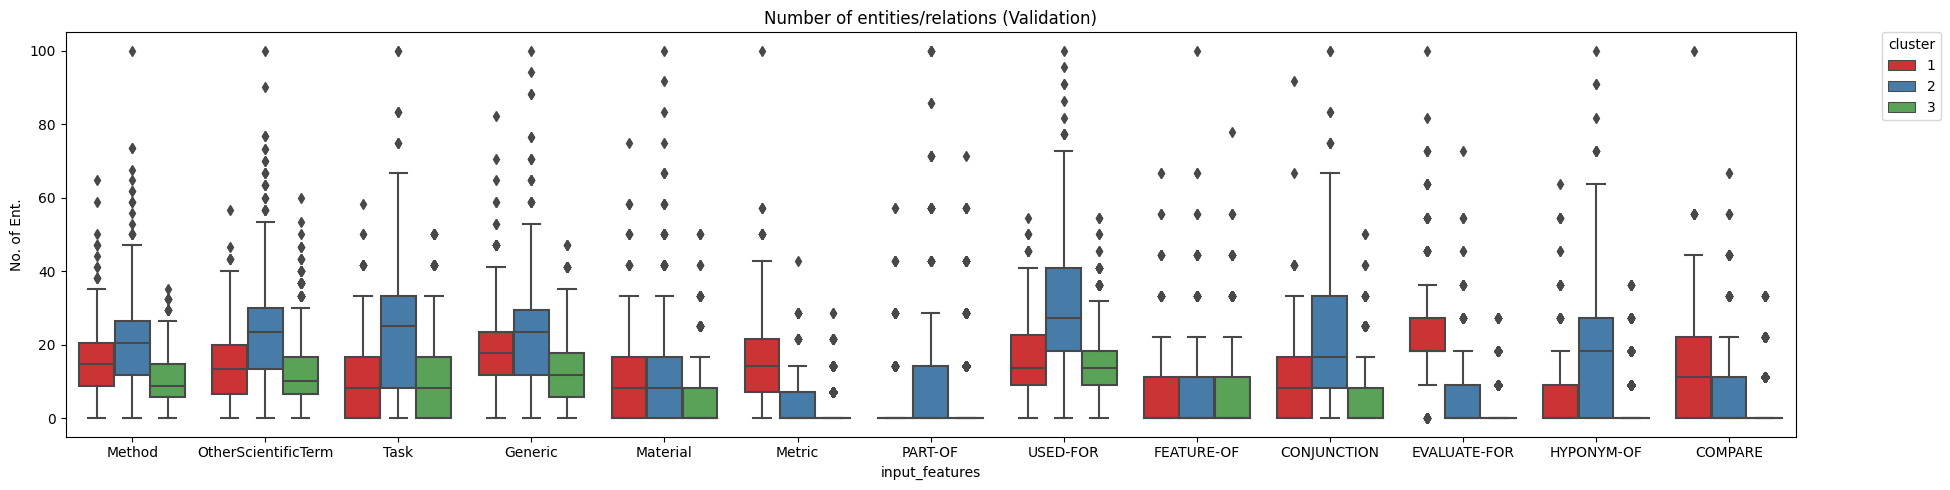

In [168]:
clust_df = model.plot_entities("val", title="Number of entities/relations (Validation)", type='perc')

In [169]:
tokens = model.plot_tokenlen("train", title='Summary length (Train)')

dist


In [170]:
tokens = model.plot_tokenlen("val", title='Summary length (Validation)')

dist


In [171]:
# for i in range(3):
#     token_cluster = tokens[tokens['cluster']==i]['token_len']
#     output_len = token_cluster.quantile(.999)
#     max_len = token_cluster.max()
#     mean_len = token_cluster.mean()
#     print(i, output_len, max_len, mean_len)

In [172]:
model.get_num_paper("train")

,num_paper,num_paper(%)
cluster,,
0,2813,14.857656
1,3110,16.426346
2,13010,68.715999


In [173]:
model.get_num_paper("val")

,num_paper,num_paper(%)
cluster,,
0,521,14.456160
1,577,16.009989
2,2506,69.533851


In [174]:
model.export_cluster("train", exp_dir="Ent_Rel")

/tmp/ipykernel_237762/3103623400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['sum_id'] = suffix_dupIndex(exp_df.set_index("paper_id"), add_one_subfix=True)


Saved 18933 sample to Ent_Rel/kmeans-k3-train-v1.csv


In [175]:
model.export_cluster("val", exp_dir="Ent_Rel")

Saved 3604 sample to Ent_Rel/kmeans-k3-val-v1.csv


/tmp/ipykernel_237762/3103623400.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df['sum_id'] = suffix_dupIndex(exp_df.set_index("paper_id"), add_one_subfix=True)


# Entity display

In [58]:
import json
def getDataset(dataset_name='MuP', section='summary', data_split='val'):
    main_path = str((Path().absolute()).parents[0])
    filepath = f"{main_path}/PL-Marker/_scire_models/{dataset_name}/{section}/{data_split}_re.json"
    with open(filepath, 'r') as json_file:
        json_list = list(json_file)
    return [json.loads(json_str) for json_str in json_list]

In [59]:
import spacy
from spacy import displacy
from spacy.tokens import Span
from pathlib import Path

colors = {
    'Task':     "#DE3163", 
    "Method":   "#6495ED", 
    "Metric":   "#FF00FF", 
    "Material": "#40E0D0", 
    "OtherScientificTerm": "#9FE2BF", 
    "Generic":  "#FFBF00",
}
options = {"ents": colors.keys(), "colors": colors, "compact": True,}
nlp = spacy.load("en_core_web_sm")

def display_ent(data, savefile=None):
    all_sentences = [j for i in data["sentences"] for j in i]
    flatten_ner = [j for i in data["predicted_ner"] for j in i]

    doc = nlp(" ".join(all_sentences))
    span_list = [Span(doc, start, end+1, ent_type) for start, end, ent_type in flatten_ner]
    doc.set_ents(span_list)
    ents = list(doc.ents)
    result = displacy.render(doc, style="ent", options=options)
    if not (savefile is None):
        output_path = Path("_output_imgs/"+savefile)
        output_path.open("w", encoding="utf-8").write(result)

In [69]:
ner_data = getDataset(dataset_name='MuP', data_split='train')
ner_data = pd.DataFrame(ner_data)
print(f"{paper_id = }")
ner_data.head()

paper_id = 'SP:ae70788404df28dd3f2e3089960d4f4e4d965bda'


,doc_key,sentences,ner,relations,predicted_ner,predicted_re
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,"[[This, paper, investigates, kernel, ridge, -,...","[[], [], [], []]","[[], [], [], []]","[[[3, 7, Method], [15, 16, OtherScientificTerm...","[[0, []], [1, [[[19, 20], [23, 24], 'USED-FOR'..."
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,"[[This, paper, presents, a, novel, way, of, ma...","[[], [], [], []]","[[], [], [], []]","[[[11, 13, Method], [16, 17, OtherScientificTe...","[[0, [[[11, 13], [16, 17], 'USED-FOR'], [[16, ..."
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,"[[This, paper, proposes, a, new, framework, th...","[[], [], [], []]","[[], [], [], []]","[[[5, 5, Generic], [9, 12, Method], [16, 17, O...","[[0, [[[9, 12], [16, 17], 'USED-FOR'], [[5, 5]..."
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,"[[This, work, proposes, a, deep, reinforcement...","[[], [], [], []]","[[], [], [], []]","[[[4, 10, Method], [13, 15, Task], [18, 20, Ta...","[[0, [[[4, 10], [13, 15], 'USED-FOR'], [[13, 1..."
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,"[[This, paper, proposes, 3, deep, generative, ...","[[], [], []]","[[], [], []]","[[[4, 6, Method], [9, 9, Method], [13, 14, Oth...","[[0, [[[4, 6], [22, 26], 'USED-FOR'], [[13, 14..."


In [116]:
cluster_train = model.cluster_dict["train"].drop(columns=model.feature_col)
cluster_train

,paper_id,summary,cluster
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge - less re...,2
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,2
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,2
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,2
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,1
...,...,...,...
18928,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,This paper presents a RNN - RL based method fo...,2
18929,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper proposes a new pointwise convolutio...,2
18930,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper presents a new pointwise convolutio...,0
18931,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,This paper proposes to model various uncertain...,1


In [116]:
cluster_train = model.cluster_dict["train"].drop(columns=model.feature_col)
cluster_train

,paper_id,summary,cluster
0,SP:4d08cdb2de2044bcb574a425b42963b83fbebfbc,This paper investigates kernel ridge - less re...,2
1,SP:b80bc890180934092cde037b49d94d6e4e06fad9,This paper presents a novel way of making full...,2
2,SP:09f2fe6a482bbd6f9bd2c62aa841f995171ba939,This paper proposes a new framework that compu...,2
3,SP:a1e2218e6943bf138aeb359e23628676b396ed66,This work proposes a deep reinforcement learni...,2
4,SP:43e525fb3fa611df7fd44bd3bc9843e57b154c66,This paper proposes 3 deep generative models b...,1
...,...,...,...
18928,SP:0d872fb4321f3a4a3fc61cf4d33b0c7e33f2d695,This paper presents a RNN - RL based method fo...,2
18929,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper proposes a new pointwise convolutio...,2
18930,SP:4706017e6f8b958c7d0825fed98b285ea2994b59,This paper presents a new pointwise convolutio...,0
18931,SP:63ad3be1dae7ede5c02a847304072c1cbc91b1cb,This paper proposes to model various uncertain...,1


In [53]:
for paper_id in set(clust_df.paper_id):
    no_clust=len(set(clust_df[clust_df.paper_id==paper_id].cluster))
    if no_clust==3: break
paper_id

'SP:ae70788404df28dd3f2e3089960d4f4e4d965bda'

In [67]:
for idx, row in dataset[dataset.doc_key==paper_id].iterrows():
    print(idx)
    display_ent(row)
    # break

15014


15015


15016


15017
